# Evaluate the structure function of the phase screen

In [10]:
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib
import MegaScreen
import numpy as np
from theory import sf_integrated
from MegaScreen import VonKarmanSpectrum, NestedSpectra

%matplotlib inline
matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["text.usetex"] = False


def multiscreen_sf(
    r0=5,
    L0=10000,
    diameter=128,
    decimate=20,
    numIter=10000,
    nfftWoofer=512,
    nfftTweeter=256,
):
    """Return the x and y structure functions of the woofer, tweeter, and summed screen"""
    args = locals()
    args["MegaScreenVersion"] = MegaScreen.__version__
    sf = []
    # Use debug=True to get the woofer and tweeter screens
    for screens in MegaScreen.MegaScreen(
        r0=r0,
        L0=L0,
        windowShape=[diameter, diameter],
        dx=diameter,
        nfftWoofer=nfftWoofer,
        nfftTweeter=nfftTweeter,
        debug=True,
        numIter=numIter,
    ):
        sf.append([average_sf_xy(screens[i], decimate) for i in range(3)])
    sf = np.mean(sf, axis=0)
    r = np.arange(sf.shape[2]) + 1
    return r, sf, args


def structure_function_brute_force(sig):
    """Return the structure function over the first dimension of an ndarray
    
    This could be done faster using an FFT but it is simpler to code the brute force
    version.
    """
    l = len(sig)
    a = [
        np.sum((sig[:-lag] - sig[lag:]) ** 2, axis=0) / (l - lag) for lag in range(1, l)
    ]
    return np.array(a)


def average_sf(sig):
    """Return the structure function in the first dimension, averaged over the last dimension"""
    a = structure_function_brute_force(sig)
    return np.mean(a, axis=-1)


def average_sf_xy(screen, decimate):
    """Return the average structure function of a 2-d screen in two dimensions
    
    Reduce the computation time by only averaging over every `decimate`th line
    """
    return (
        average_sf(screen[:, ::decimate]),
        average_sf(screen.transpose()[:, ::decimate]),
    )

In [12]:
print("This may take some time...")
r,sf,args=multiscreen_sf(numIter=1000)
print("..done")

This may take some time...
..done


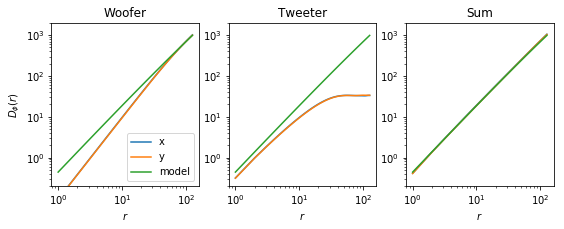

In [13]:
def plot_all(r, results, meta):
    plt.figure(figsize=(9, 3))
    for i, title in enumerate(["Woofer", "Tweeter", "Sum"]):
        plt.subplot(1, 3, i + 1)
        sf_x, sf_y = results[i]
        plt.loglog(r, sf_x, label="x")
        plt.loglog(r, sf_y, label="y")
        plot_theory(r, meta)
        if i == 0:
            plt.ylabel(r"$D_\phi(r)$")
            plt.legend(loc="lower right")
        plt.xlabel(r"$r$")
        plt.title(title)
        plt.ylim(2e-1, 2e3)


def plot_theory(r, meta):
    model = sf_integrated(r, r0=meta["r0"], L0=meta["L0"])
    plt.loglog(r, model, label="model")


plot_all(r, sf, args)
# plt.savefig("component_sf.png")